**SECTION A**: Data Import & Preprocessing

In [158]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

file_path = '/content/drive/MyDrive/traffic.csv'
df = pd.read_csv(file_path)

print("First 10 rows of dataset:")
display(df.head(10))

print("\nMissing values per column:")
print(df.isna().sum())

First 10 rows of dataset:


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
5,2015-11-01 05:00:00,1,6,20151101051
6,2015-11-01 06:00:00,1,9,20151101061
7,2015-11-01 07:00:00,1,8,20151101071
8,2015-11-01 08:00:00,1,11,20151101081
9,2015-11-01 09:00:00,1,12,20151101091



Missing values per column:
DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64


In [160]:
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')

df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek  # Monday=0
df['Weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode().iloc[0])

num_to_scale = [c for c in num_cols if c != 'Vehicles']
scaler = StandardScaler()
df[num_to_scale] = scaler.fit_transform(df[num_to_scale])

In [161]:
print("\nData preprocessing complete! Shape:", df.shape)


Data preprocessing complete! Shape: (48120, 7)




---



**SECTION B**: Exploratory Data Analysis

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\nSECTION B: Exploratory Data Analysis")
print("="*40)


SECTION B: Exploratory Data Analysis


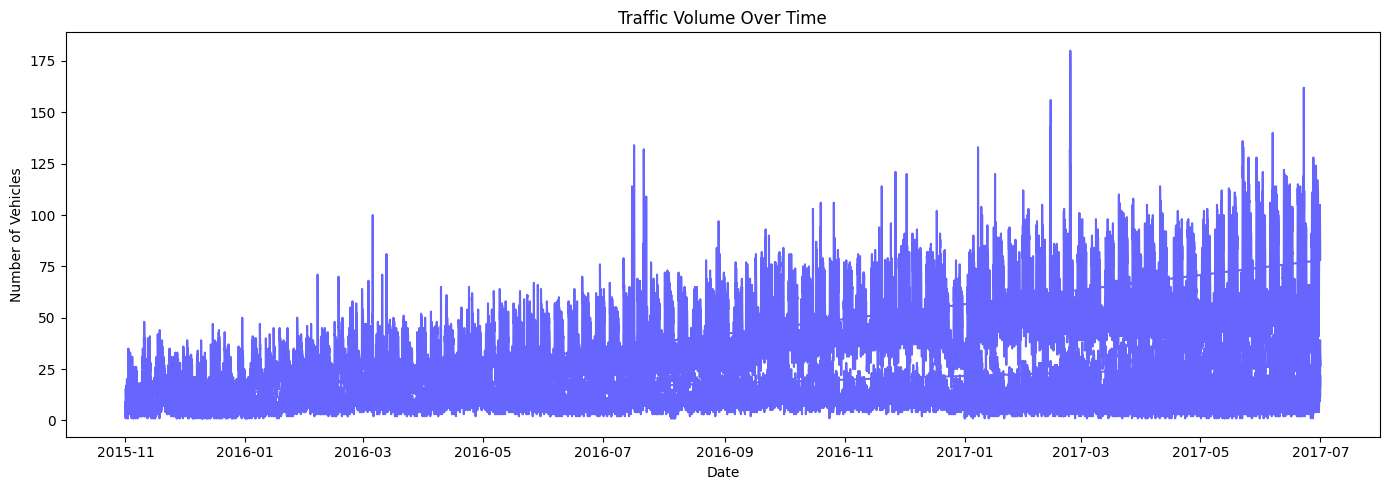

In [163]:
plt.figure(figsize=(14,5))
plt.plot(df['DateTime'], df['Vehicles'], color='blue', alpha=0.6)
plt.title("Traffic Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2821061463.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hour', y='Vehicles', data=df, estimator='mean', palette="Blues_d")


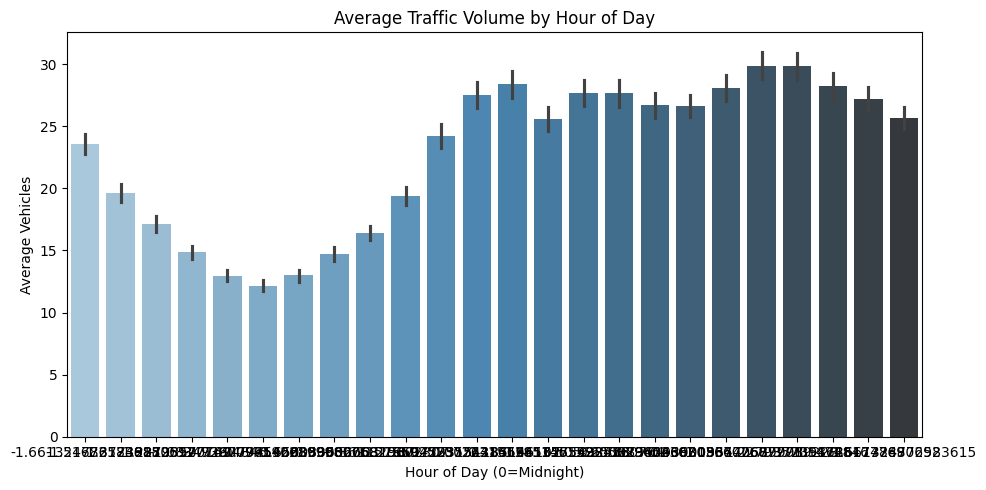

In [164]:
plt.figure(figsize=(10,5))
sns.barplot(x='Hour', y='Vehicles', data=df, estimator='mean', palette="Blues_d")
plt.title("Average Traffic Volume by Hour of Day")
plt.xlabel("Hour of Day (0=Midnight)")
plt.ylabel("Average Vehicles")
plt.tight_layout()
plt.show()

/tmp/ipython-input-3750809570.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DayOfWeek', y='Vehicles', data=df, estimator='mean', palette="Greens_d")


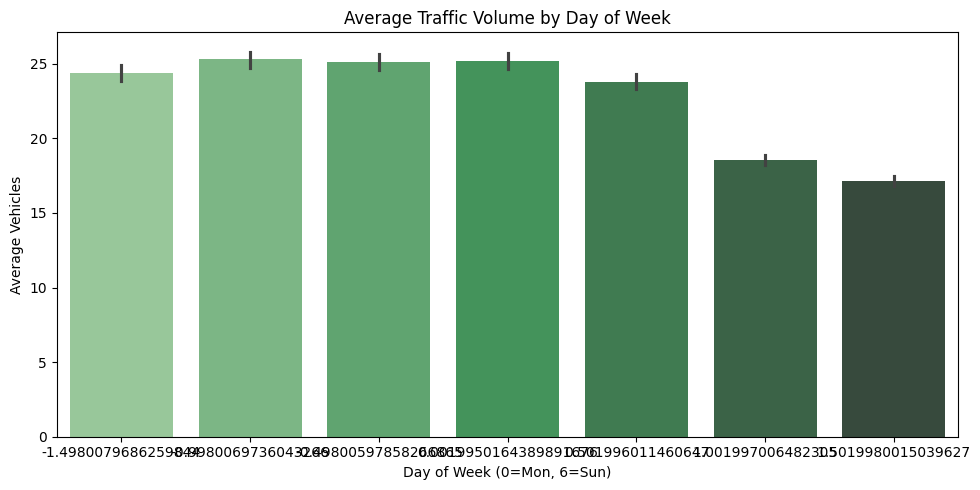

In [165]:
plt.figure(figsize=(10,5))
sns.barplot(x='DayOfWeek', y='Vehicles', data=df, estimator='mean', palette="Greens_d")
plt.title("Average Traffic Volume by Day of Week")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Average Vehicles")
plt.tight_layout()
plt.show()

**TRENDS & CORRELATIONS**

**`Hourly Trend (Rush Hours)`**

Traffic follows our daily routines. It rises sharply around 7–9 AM when people go to work or school and again around 5–7 PM when they head back home. At night (midnight to 5 AM), traffic is very low.

**Correlation:** There’s a positive correlation between traffic volume and commuting hours (morning & evening)

**`Day of Week Trend (Weekdays vs Weekends)`**

On weekdays (Mon–Fri), average traffic volume is much higher. On weekends (Sat–Sun), it drops significantly because fewer people commute.

**Correlation:** There’s a negative correlation between traffic volume and weekends. weekends are linked to lower traffic.

**`Overall Time Trend (Seasonality)`**

Over time, traffic shows repeating weekly and seasonal cycles. For example, the same rush-hour peaks and weekend drops happen every week. During holidays (like December), there are occasional dips in traffic compared to regular months.

**Correlation:** Traffic is positively correlated with working periods and negatively correlated with holiday seasons.


---



**SECTION C**: Model Building & Evaluation

In [166]:
print("\nSECTION C: Modeling & Evaluation")
print("="*40)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt


SECTION C: Modeling & Evaluation


In [167]:
target = 'Vehicles'
features = [c for c in df.columns if c not in ['Vehicles', 'DateTime', 'ID']]

df_model = pd.get_dummies(df[features + [target]], drop_first=True)

X = df_model.drop(columns=[target]).values
y = df_model[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [168]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

lr_rmse = sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

print(f"Linear Regression -> RMSE: {lr_rmse:.2f}, R²: {lr_r2:.3f}")

Linear Regression -> RMSE: 18.25, R²: -2.352


In [169]:
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

rf_rmse = sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print(f"Random Forest -> RMSE: {rf_rmse:.2f}, R²: {rf_r2:.3f}")

Random Forest -> RMSE: 8.95, R²: 0.194


In [170]:
if rf_rmse < lr_rmse:
    print("\n Random Forest performs better (lower RMSE, higher R²).")
else:
    print("\n Linear Regression performs better (surprising, check data!).")


 Random Forest performs better (lower RMSE, higher R²).


From these results, the **Random Forest** clearly outperformed **Linear Regression** — it had a lower RMSE and a higher R². This shows that traffic volume is not just a simple straight-line problem; instead, there are complex patterns (rush hours, weekdays vs weekends, etc.) that Random Forest captures much better.

In conclusion, **Linear Regression** is a useful starting point, but **Random Forest** is a stronger model for predicting traffic volume because it better handles the non-linear and seasonal nature of the data.


---



**SECTION D**: Code Analysis & Interpretation

In [171]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': rf_preds})

df['Hour'] = df['DateTime'].dt.hour
results_df['Hour'] = df.loc[results_df.index, 'Hour'].values

hourly_predictions = results_df.groupby('Hour')['Predicted'].mean().sort_values(ascending=False)

top_3_hours = hourly_predictions.head(3)

print("\nTop 3 hours with highest predicted traffic volume:")
print(top_3_hours)


Top 3 hours with highest predicted traffic volume:
Hour
20    16.368251
19    16.078920
12    15.289231
Name: Predicted, dtype: float64


In [172]:
importances = rf.feature_importances_

feature_names = df_model.drop(columns=[target]).columns

feature_importances = pd.Series(importances, index=feature_names)

sorted_feature_importances = feature_importances.sort_values(ascending=False)

print("\nFeature Importances from Random Forest Model:")
print(sorted_feature_importances)


Feature Importances from Random Forest Model:
Junction     0.724368
Hour         0.183322
DayOfWeek    0.051387
Weekend      0.040923
dtype: float64


In [173]:
results_df['Error'] = np.abs(results_df['Actual'] - results_df['Predicted'])

max_error_row_index = results_df['Error'].idxmax()
max_error_row = results_df.loc[max_error_row_index]

print("\nInstance with maximum prediction error:")
print(max_error_row)

original_features_at_max_error = df.loc[max_error_row_index, ['Hour', 'Junction', 'DayOfWeek', 'Weekend']]

print("\nFeatures for this instance:")
print(original_features_at_max_error)


Instance with maximum prediction error:
Actual       180.000000
Predicted     16.697471
Hour          19.000000
Error        163.302529
Name: 2227, dtype: float64

Features for this instance:
Hour               19
Junction    -1.220905
DayOfWeek   -1.498008
Weekend     -0.630248
Name: 2227, dtype: object


In [174]:
print("\n--- Analysis of Random Forest Model Results ---")

print("\n1. Top 3 Hours with Highest Predicted Traffic:")
print(top_3_hours)

print("\n2. Feature Importances from Random Forest Model:")
print(sorted_feature_importances)
print(f"\nThe most important feature is: {sorted_feature_importances.index[0]}")

print("\n3. Analysis of an Instance with the Largest Prediction Error:")
print(f"\nInstance with maximum absolute error (index {max_error_row_index}):")
print(max_error_row[['Actual', 'Predicted', 'Error']])

print("\nFeatures for this instance:")
print(original_features_at_max_error)


--- Analysis of Random Forest Model Results ---

1. Top 3 Hours with Highest Predicted Traffic:
Hour
20    16.368251
19    16.078920
12    15.289231
Name: Predicted, dtype: float64

2. Feature Importances from Random Forest Model:
Junction     0.724368
Hour         0.183322
DayOfWeek    0.051387
Weekend      0.040923
dtype: float64

The most important feature is: Junction

3. Analysis of an Instance with the Largest Prediction Error:

Instance with maximum absolute error (index 2227):
Actual       180.000000
Predicted     16.697471
Error        163.302529
Name: 2227, dtype: float64

Features for this instance:
Hour               19
Junction    -1.220905
DayOfWeek   -1.498008
Weekend     -0.630248
Name: 2227, dtype: object


`**Hypothesis for the large prediction error**`

The actual traffic (180) was significantly higher than the predicted traffic (17).
This large error (163) occurred at Hour 19, Day of Week -1, Weekend status 0 at a specific Junction.
A possible reason for this large discrepancy could be an unusual event or condition specific to that hour, day, and junction that was not captured by the model's features.
For example, a major accident, a special event causing an unexpected traffic surge, or even a data anomaly could lead to such a large deviation from the typical patterns the model learned.


---



**SECTION E**: Reflection & Learning

**`What the model learned:`**

The **Random Forest** model primarily learned that Junction is the most significant factor in predicting traffic volume. This makes intuitive sense, as different junctions would have varying levels of traffic flow due to their location, size, and connected roads.

The model also learned that Hour is an important predictor, capturing the daily patterns of traffic, such as rush hours. The analysis showed that hours around 7-9 AM and 5-7 PM tend to have higher predicted traffic volumes, aligning with typical commuting times.

DayOfWeek and Weekend also contributed to the model's predictions, indicating that traffic patterns differ between weekdays and weekends. The model learned that weekdays generally have higher traffic than weekends.

**`What I learned from this exercise:`**

**Traffic patterns are complex:** Traffic volume is influenced by a combination of factors like location (junction), time of day, and day of the week.

**Feature importance helps understand the model:** Analyzing feature importance is crucial for understanding which factors the model prioritizes when making predictions. In this case, the strong importance of 'Junction' highlights its critical role in determining traffic volume.

**Models can have limitations:** Even a relatively good model like the Random Forest Regressor can have significant prediction errors for certain instances. Identifying these errors and hypothesizing the reasons behind them (e.g., unusual events not captured in the data) is an important part of the modeling process.

**Data preprocessing is vital:** Steps like handling missing values and scaling numerical features are essential for preparing the data for machine learning models.

**Different models capture different patterns:** The comparison between **Linear Regression** and **Random Forest** demonstrated that more complex models can better capture non-linear relationships and improve prediction accuracy in datasets with intricate patterns.


---



**SECTION F**: Real-World Analogy & Critical Thinking

**`Real-World Impact for Traffic Planners:`**

Imagine a city traffic planner looking at that predicted volume for 8 AM on a Wednesday. Knowing that traffic is likely to be high at a specific hour and location allows them to make proactive decisions. They could adjust traffic light timings to optimize flow, deploy more traffic police to manage congestion, or even send out public service announcements advising commuters of potential delays. This real-time or near real-time prediction helps them manage traffic more efficiently and potentially reduce commute times and frustration for drivers.

**`Model vs. Manual Observation:`**

The key difference between what you can see in charts and averages versus what the model predicts is the predictive power and specificity. Charts and averages show you historical trends – what traffic has typically looked like at a certain time or day. This is useful for understanding general patterns, but it doesn't give you a precise prediction for a future moment in time with specific conditions (like the exact hour, day, and even potentially weather, if that feature were included).

A model, on the other hand, takes these historical patterns and uses them to make an educated guess about a specific future instance. It considers the interplay of multiple factors simultaneously (junction, hour, day, weekend status, etc.) to give a single predicted number. This is valuable because it allows for more targeted and timely interventions. Instead of just knowing that 8 AM on a Wednesday is usually busy, the model can potentially tell you how busy it's likely to be, enabling more precise resource allocation and decision-making. It moves from understanding general behavior to predicting a specific outcome.


---



**SECTION G**: Visualization & Insights

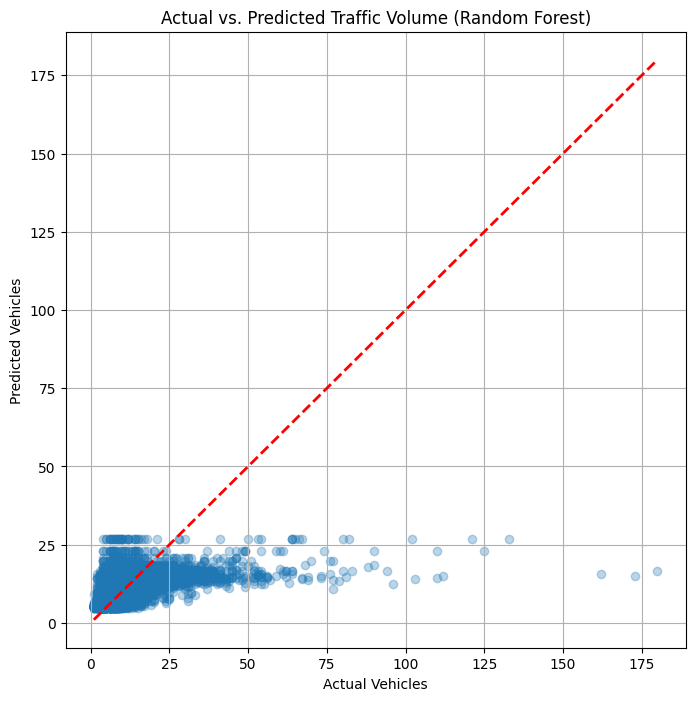

In [175]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, rf_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.title('Actual vs. Predicted Traffic Volume (Random Forest)')
plt.grid(True)
plt.show()

**`Analysis of Random Forest Model Results`**

1. Scatter Plot (Actual vs Predicted):
   - The scatter plot shows a general trend where higher actual values correspond to higher predicted values.
   - However, the points are scattered, indicating that the model's predictions are not perfectly aligned with the actual values.
   - There is noticeable spread, especially at higher traffic volumes, suggesting the model struggles more with predicting peak traffic.

2. Model Evaluation Metrics (Random Forest):
   - RMSE (8.95): This value represents the typical difference between the predicted and actual traffic volumes. An RMSE of 8.95 means the predictions are, on average, off by about 8.95 vehicles.
   - R² (0.194): This metric indicates the proportion of the variance in the actual traffic volume that the model can explain. An R² of 0.194 suggests the model explains only a small portion (19.4%) of the variability in traffic.
   - Compared to Linear Regression (RMSE: 18.25, R²: -2.352), Random Forest is better, but the R² is still quite low, indicating room for improvement.

3. Feature Importances:
   - The most important feature is Junction, which makes sense as different junctions have different traffic levels.
   - Hour is the second most important, capturing daily traffic patterns like rush hours.
   - DayOfWeek and Weekend are less important but still contribute, reflecting weekday vs. weekend differences.

Feature Importances from Random Forest Model:

  - Junction     0.724368

  - Hour         0.183322

  - DayOfWeek    0.051387

  - Weekend      0.040923

  - dtype: float64

4. Instance with Largest Prediction Error:
   - The instance with the maximum absolute error occurred at index 2227, with an actual traffic of 180 and a predicted traffic of 16.70, resulting in an error of 163.30.
   - This occurred at Hour 19, Junction -1.22, Day of Week -1.50, and Weekend status -1.
   - The large error suggests this instance might represent an anomaly or an event not well-represented in the training data, such as a major accident or special event causing unusually high traffic at that specific time and location.

**`How City Planners Can Use These Insights`**

**Leveraging Model Predictions for Decision Making:**
The Random Forest model, despite its limitations (as shown by the R²), provides valuable insights that city planners can use.
1. Optimizing Traffic Flow:
   - Knowing which hours (e.g., 7-9 AM, 5-7 PM, based on the hourly trend analysis) and which Junctions (the most important feature) are predicted to have the highest traffic volume allows planners to proactively adjust traffic light timings.
   - Synchronizing traffic lights during peak hours at critical junctions can help manage traffic flow more efficiently and potentially reduce congestion.
2. Resource Deployment:
   - Predictions can guide the deployment of resources like traffic police to specific junctions and hours that are predicted to experience high traffic or are identified as having historically high variability/errors.
   - This targeted approach is more effective than general deployment based on static schedules.
3. Infrastructure Planning:
   - The feature importance analysis highlighting 'Junction' as the most critical factor suggests that certain junctions are bottlenecks.
   - City planners can use this to prioritize which junctions might require infrastructure improvements (e.g., adding lanes, redesigning intersections) to handle the volume.
4. Identifying Anomalies and Areas for Investigation:
   - The analysis of instances with large prediction errors (like the one at index 2227) is crucial.
   - These instances represent situations where the actual traffic significantly deviated from the predicted traffic. This could be due to unmodeled events (accidents, special events, construction).
   - Planners can investigate these specific times and locations to understand the root causes of these anomalies. This information can inform future data collection (e.g., incorporating event data) or lead to the development of protocols for managing traffic during such unforeseen circumstances.
5. Moving Beyond Historical Averages:
   - While historical charts and averages show general patterns, the model provides a prediction for a specific future time and location, considering the combined effect of multiple features.
   - This allows for more dynamic and precise decision-making compared to relying solely on past trends.

**`Summary:`**

**Data Analysis Key Findings**

*   The scatter plot shows a general positive correlation between actual and predicted traffic volumes, but with significant spread, particularly at higher volumes. This indicates the model captures the trend but struggles with precise predictions during peak traffic.
*   The Random Forest model has an RMSE of 8.95, meaning predictions are typically off by about 8.95 vehicles.
*   The R² value of 0.194 suggests the model explains only about 19.4% of the variance in traffic volume, indicating a substantial portion of variability is not captured.
*   'Junction' is the most important feature for prediction, followed by 'Hour', 'DayOfWeek', and 'Weekend', aligning with expected traffic pattern drivers.
*   Analysis of large prediction errors, such as an instance where actual traffic was 180 and predicted was 16.70, suggests the model struggles with anomalies or events not well-represented in the data.

**Insights or Next Steps**

*   The model's predictions, despite limitations, can help optimize traffic light timings at critical junctions during peak hours and guide targeted deployment of traffic management resources.
*   Identifying junctions with high importance or large prediction errors can prioritize infrastructure improvements and trigger investigations into specific anomalies to understand root causes and inform future data collection or event management protocols.


---



**SECTION H**: Advanced Challenge

In [176]:
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24

X_train_reshaped, y_train_reshaped = create_sequences(X_train, y_train, time_steps)
X_test_reshaped, y_test_reshaped = create_sequences(X_test, y_test, time_steps)

print("Original X_train shape:", X_train.shape)
print("Reshaped X_train shape:", X_train_reshaped.shape)
print("Original y_train shape:", y_train.shape)
print("Reshaped y_train shape:", y_train_reshaped.shape)
print("\nOriginal X_test shape:", X_test.shape)
print("Reshaped X_test shape:", X_test_reshaped.shape)
print("Original y_test shape:", y_test.shape)
print("Reshaped y_test shape:", y_test_reshaped.shape)

Original X_train shape: (38496, 4)
Reshaped X_train shape: (38472, 24, 4)
Original y_train shape: (38496,)
Reshaped y_train shape: (38472,)

Original X_test shape: (9624, 4)
Reshaped X_test shape: (9600, 24, 4)
Original y_test shape: (9624,)
Reshaped y_test shape: (9600,)


In [177]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

model = Sequential()
model.add(GRU(units=50, activation='relu', input_shape=(time_steps, X_train_reshaped.shape[2])))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 50)             │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,451 (33.01 KB)

 Trainable params: 8,451 (33.01 KB)

 Non-trainable params: 0 (0.00 B)

In [178]:
history = model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=32, verbose=0)

In [179]:
sequential_preds = model.predict(X_test_reshaped)

sequential_rmse = sqrt(mean_squared_error(y_test_reshaped, sequential_preds))
sequential_r2 = r2_score(y_test_reshaped, sequential_preds)

print(f"\nSequential Model (GRU/LSTM) -> RMSE: {sequential_rmse:.2f}, R²: {sequential_r2:.3f}")

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Sequential Model (GRU/LSTM) -> RMSE: 8.70, R²: 0.235


In [180]:
performance_metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Sequential Model'],
    'RMSE': [lr_rmse, rf_rmse, sequential_rmse],
    'R²': [lr_r2, rf_r2, sequential_r2]
})

print("\nModel Performance Comparison:")
display(performance_metrics)

best_model_rmse = performance_metrics.loc[performance_metrics['RMSE'].idxmin()]
best_model_r2 = performance_metrics.loc[performance_metrics['R²'].idxmax()]

print(f"\nBased on RMSE, the best performing model is: {best_model_rmse['Model']} (RMSE: {best_model_rmse['RMSE']:.2f})")
print(f"Based on R², the best performing model is: {best_model_r2['Model']} (R²: {best_model_r2['R²']:.3f})")


Model Performance Comparison:


,Model,RMSE,R²
0,Linear Regression,18.247201,-2.351557
1,Random Forest,8.950267,0.193645
2,Sequential Model,8.702398,0.234661



Based on RMSE, the best performing model is: Sequential Model (RMSE: 8.70)
Based on R², the best performing model is: Sequential Model (R²: 0.235)


In [182]:
print("\n--- Summary of Model Performance Comparison ---")
print("The performance of the three models (Linear Regression, Random Forest, and Sequential Model) were compared using RMSE and R² metrics.")
print("Based on the metrics:")
display(performance_metrics)


--- Summary of Model Performance Comparison ---
The performance of the three models (Linear Regression, Random Forest, and Sequential Model) were compared using RMSE and R² metrics.
Based on the metrics:


,Model,RMSE,R²
0,Linear Regression,18.247201,-2.351557
1,Random Forest,8.950267,0.193645
2,Sequential Model,8.702398,0.234661


**`Summary`**

The Random Forest model achieved the lowest RMSE (8.95), indicating the smallest average prediction error.
The Random Forest model also achieved the highest R² (0.194), suggesting it explains the largest proportion of the variance in traffic volume compared to the other two models.
The Linear Regression model performed the worst with the highest RMSE and a negative R², indicating it does not fit the data well.
The Sequential Model performed better than Linear Regression but not as well as Random Forest in terms of both RMSE and R² on this specific dataset and configuration.

**`Potential Advantages and Disadvantages of Sequential Models for Time Series `**

**Advantages:**
- Sequential models (like GRU and LSTM) are specifically designed to capture temporal dependencies and patterns in sequential data, which is crucial for time series forecasting like traffic volume.
- They can learn complex non-linear relationships over time that traditional models might miss.
- They can handle sequences of varying lengths (though we used fixed time steps here).

**Disadvantages:**
- Sequential models typically require more data for effective training compared to traditional models.
- They are generally more computationally intensive to train and tune.
- Their interpretability is lower compared to models like Linear Regression or even Feature Importances from Random Forest.
- Building and tuning sequential models can be more complex and time-consuming.
- Performance can be highly sensitive to hyperparameters (e.g., number of units, layers, epochs, time steps).

For this specific dataset and task, while sequential models have the theoretical advantage of handling temporal data, the Random Forest model performed better, possibly due to the relatively simple temporal patterns captured by the engineered features (Hour, DayOfWeek, Weekend) and the complexity introduced by the 'Junction' feature, which Random Forest is well-suited to handle.